<head>
  <script type="text/x-mathjax-config"> MathJax.Hub.Config({ TeX: { equationNumbers: { tags: 'ams' } } }); </script>
  <script type="text/x-mathjax-config">
    MathJax.Hub.Config({
      tex2jax: {
        extensions: ["amsthm.js", "AMSmath.js","AMSsymbols.js", "autobold.js"],
        inlineMath: [ ['$','$'], ["\\(","\\)"] ],
         displayMath: [ ['$$','$$'], ["\\[","\\]"] ],
         processEscapes: true
      }
    });
  </script>
  <script src="https://cdn.mathjax.org/mathjax/latest/MathJax.js?config=TeX-AMS-MML_HTMLorMML" type="text/javascript">
  </script>
  <meta name="google-site-verification" content="kuks5e4as6qBaGVCSzmHkQJa5Tss89_g5DmRXeUi7K8" />

  <style> 
  body{
    .previous {
    background-color: #f1f1f1;
    color: black;
    }
    .next {
      background-color: #04AA6D;
      color: white;
    }
    .example,.theorem,.lemma,.problem, .definition {
       font-weight:bold; 
    }
  }
  </style>
</head>

<a href="MetropolisHastingsAlg" class="previous"> &laquo; Back<a>  <a href="index" class="next"> &raquo; Table of Contents<a> 

<h1>A Quick Intro to PyMC3 </h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3
import arviz
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


The following data is 

In [2]:
file_name = 'data/chemical_shifts.csv'

data = np.loadtxt(file_name)
data[0:5]

array([51.06, 55.12, 53.73, 50.24, 52.05])

In [3]:
len(data)

48

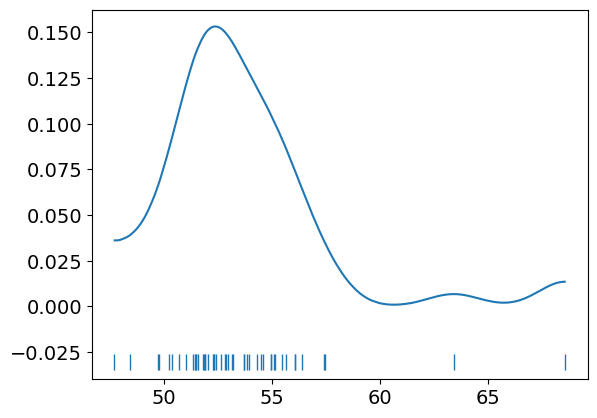

In [4]:
arviz.plot_kde(data, rug=True,)
plt.show()


The KDE plot of this dataset suggests that,  except for a couple of observations, a bell shape distribution is a good approximation for the likelihood of this data. 

In this example we are going to make some Bayesian inference on the mean and variance of this distribution. First we are going to ignore the two 'outliers' and consider a Normal distribution for the likelihood. Then we will consider ommiting these two observations and compare both inference analysis.



Since we have no prior idea on the mean $\mu$ and the variance $\sigma^2$ of the data we will set non informative priors on both parameters. For the mean we will take as prior a uniform distirbution in the range of the data itself and for the variance we will consider the absolute value of a normal distribution, this in order to obtain a random variable with support $\mathbb{R}_{\geq 0}$. This distribution is known as *Half Normal* and it is already implemented as part of the distributions in **PyMC3**.

The model then will be of the type:

$$
\begin{align*}
\mu \sim \mathcal{U}(a, b)\\
\sigma \sim \vert \mathcal{N}(0, \sigma_0^2)\vert \\
y \sim \mathcal{N}(\mu, \sigma^2)
\end{align*}
$$

with $a = \min(data), b = \max(data)$ and $\sigma_0 = 50$, for this latter parameter we can set any ad-hoc value since we have no prior knowledge on the variance. 

Now, let us set the model, which we will call $model_0$, in **PyMC3**:

In [5]:
a = np.floor(np.min(data) - 10)
b = np.ceil(np.max(data) + 10)
sigma_0 = 100

with pymc3.Model() as model_0:
    mu_prior = pymc3.Uniform('$\mu$',lower = a, upper= b)
    sigma_prior = pymc3.HalfNormal('$\sigma$', sd = sigma_0)
    y_likelihood = pymc3.Normal('y', mu = mu_prior, sd = sigma_prior, observed = data)
    infered_data = pymc3.sample(draws=1000, chains = 3, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [$\sigma$, $\mu$]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/Users/juliana/opt/anaconda3/envs/Gatulin/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juliana/opt/anaconda3/envs/Gatulin/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juliana/opt/anaconda3/envs/Gatulin/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 9 seconds.


In [6]:
infered_data

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

Now, let us plot the results:

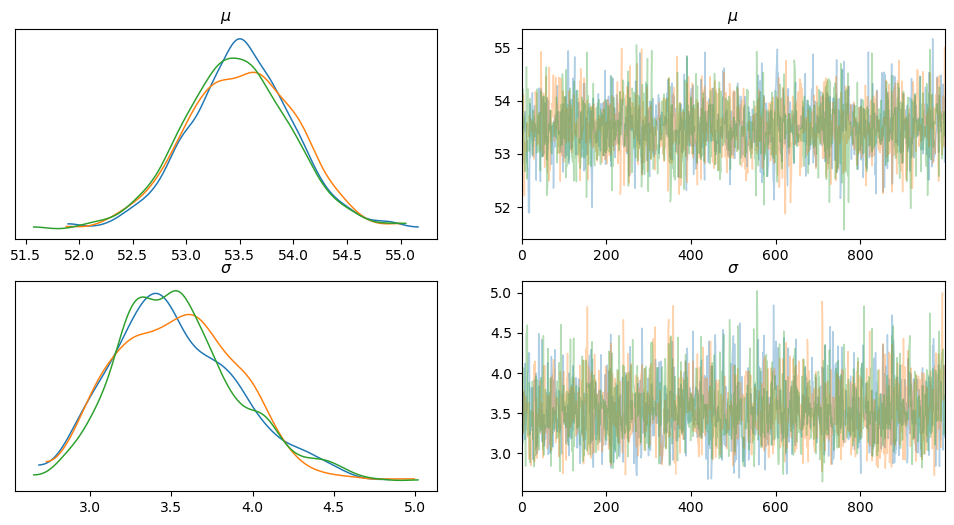

In [7]:
arviz.plot_trace(infered_data, compact=False, figsize=(12, 6))
plt.show()

PymC3 runs three Markov chains for us and we can see in the plot above the KDE's of each chain for each parameter (left) and the trajectories or values of each draw.  By setting the parameter *combine* to True, the plot_trace function combines the three chains into one. Let's see the result of doing this:

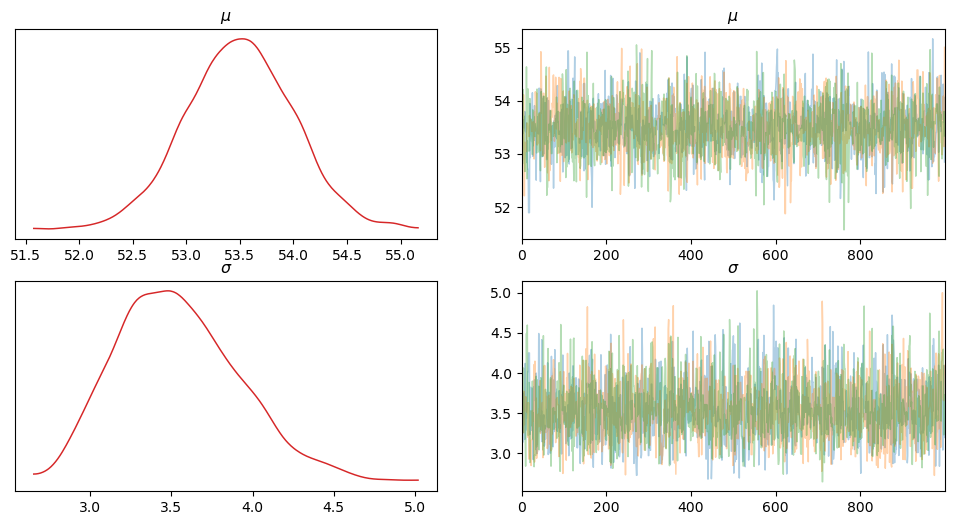

In [8]:
arviz.plot_trace(infered_data, combined = True, compact=False, figsize=(12, 6))
plt.show()

The function *summary* from ArviZ library gives us a summary of the results of the MCMC algorithm. It returns a pandas data frame with all the statistics of the Markov Chain such as the estimated mean and standard deviation for each parameter, the 94% high density interval although we can ask for other sizes by setting the *hdi_prob* to the required value, the Markov chain standard error for the mean and standar deviation estimations, the effective sample size computed with two methods (ess_bulk, ess_tail) which tell us the amount of independent samples would be necessary to obtained similar estimations; the nearer this number is to the total of samples the better. Finally the r_hat which tell us the ratio of variability in the chains to the variability within the chains.

The plot above for the KDE for each parameter correspond to the estimation of the marginal densities. We can also plot the KDE of the joint density with the function *plot_pair* form Arviz:

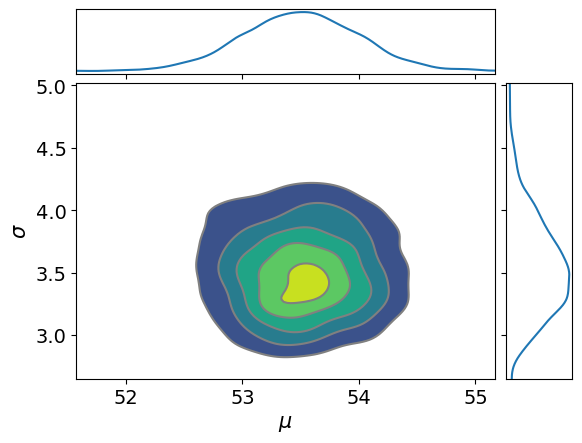

In [9]:
arviz.plot_pair(infered_data, kind = 'kde',  marginals = True, )
plt.show()

If we wanted to get access to the drwas of each parameter we can index the posterior and indicate the variable (in this case we have two) and also the chain from which we want the samples.

In [10]:
infered_data.posterior['$\mu$'][0].to_numpy()[0:10]

array([53.35476037, 53.45003486, 53.37961168, 53.62442727, 53.64037276,
       53.49560377, 53.49560377, 53.79726556, 53.42916389, 53.41942054])

We can combine the samples from the three chains into a big numpy array:

In [11]:
mu_samples = infered_data.posterior['$\mu$'][0:3].to_numpy()

In [12]:
mu_samples.shape

(3, 1000)

<h3> Posterior Predictive Checks </h3>

Now, with the posterior samples obtained via the MCMC we can simulate new data and check how consistent this simulated data is with respect to the observed data. This is a kind of diagnosis of the model since we are going to use these posterior samples to make some predictions and use them to check the model.

With the function *sample_posterior_predictive* we generate of samples of the variable $Y$ each of these set with the size of the original data:

In [13]:
y_pred_model0 = pymc3.sample_posterior_predictive(trace = infered_data, model=model_0, keep_size=True)

This function returns a Dictionary object with keys the name of the observed variable which we  called 'y' and the value is a numpy array of shape $(chains, draws, len(data))$, this because we set the parameter *keep_size* equals to True in order to be able to make a posterior predictive check (ppc) plot 

In [14]:
print(y_pred_model0['y'].shape)

(3, 1000, 48)


In [15]:
y_pred_model0['y'][0,0,0:10]

array([58.14823624, 57.68249386, 46.18514987, 55.28961718, 57.00301707,
       57.16203663, 54.3395682 , 57.83787608, 53.90723813, 53.9189246 ])

Now, we add these posterior predictive samples to the object *infered_data* using the function *concat* from Arviz:

In [16]:
ppc_data = arviz.concat(infered_data, arviz.from_dict(posterior_predictive= y_pred_model0), inplace=False)
ppc_data

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

Check that in fact these posterior predictive samples are the ones saved in *y_pred_model0*:

In [17]:
ppc_data.posterior_predictive['y'].to_numpy()[0,0, 0:10]

array([58.14823624, 57.68249386, 46.18514987, 55.28961718, 57.00301707,
       57.16203663, 54.3395682 , 57.83787608, 53.90723813, 53.9189246 ])

Now, let us make the *ppc* plot:

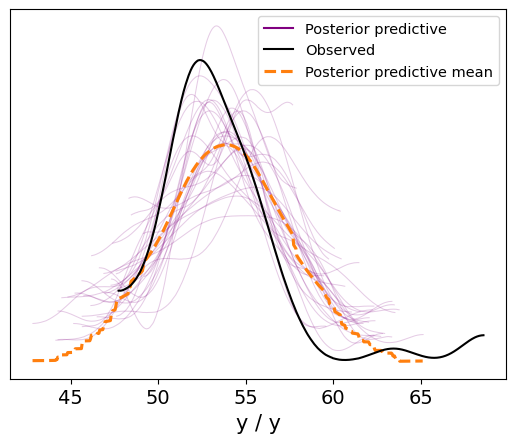

In [43]:

arviz.plot_ppc(data=ppc_data,num_pp_samples= 30, data_pairs={"y":"y"}, color='purple', random_seed= 33)
plt.show()


The curves in light purple are the KDE plots of num_pp_samples =10 sets of 48 samples randomly chosen from the posterior predictive simulated data. The orange dashed curve is the average of all the light purple curves. The black curve is the KDE plot of the observed data. What one hopes to see in this plot is that the light curves surrounds the black curve. This provides confidence that our model is able to produce data similar to the observed one.

Let us make tha same analysis but dropping out the two points from the observed data that seemed to be outliers. This of course is completely adhoc since we don't really know whether they are outliers or not.

In [44]:
mask = data > 60
sum(mask)

2

48 46


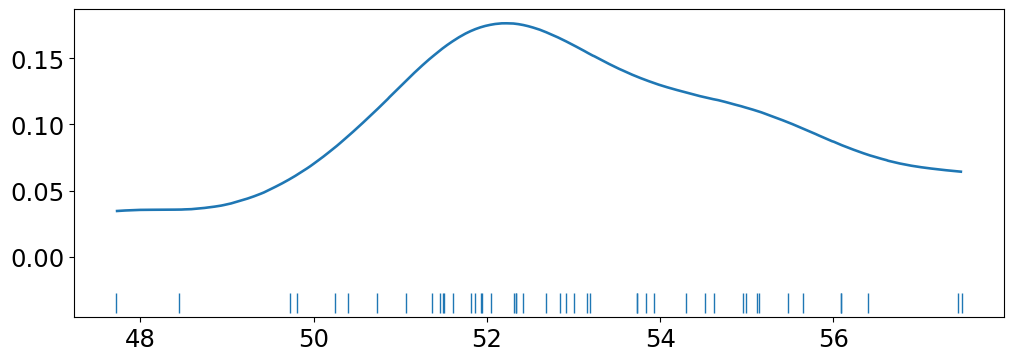

In [45]:
data_reduced = data[~mask]
print(len(data), len(data_reduced))

arviz.plot_kde(data_reduced, figsize=(12,4), rug = True)
plt.show()

In [46]:
with pymc3.Model() as model_1:
    mu_prior = pymc3.Uniform('$\mu$',lower = a, upper= b)
    sigma_prior = pymc3.HalfNormal('$\sigma$', sd = sigma_0)
    y_likelihood = pymc3.Normal('y', mu = mu_prior, sd = sigma_prior, observed = data_reduced)
    infered_data_1 = pymc3.sample(draws=1000, chains = 3, return_inferencedata=True)

y_pred_model1 = pymc3.sample_posterior_predictive(trace = infered_data_1, model=model_1, keep_size=True)

ppc_data_reduced = arviz.concat(infered_data_1, arviz.from_dict(posterior_predictive= y_pred_model1), inplace=False)
ppc_data_reduced


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [$\sigma$, $\mu$]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


/Users/juliana/opt/anaconda3/envs/Gatulin/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juliana/opt/anaconda3/envs/Gatulin/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/juliana/opt/anaconda3/envs/Gatulin/lib/python3.10/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 10 seconds.


Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

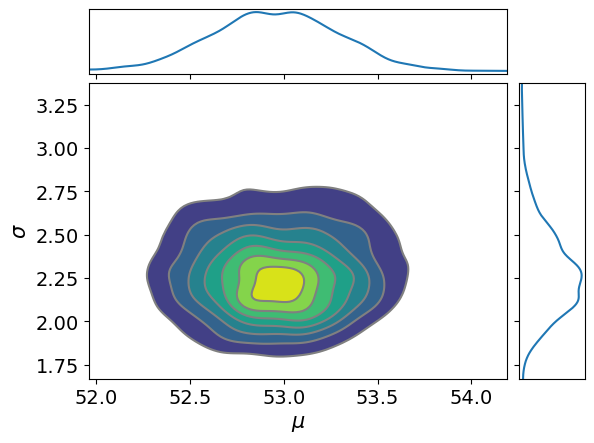

In [59]:

arviz.plot_pair(infered_data_1, kind = 'kde',  marginals = True, )
plt.show()



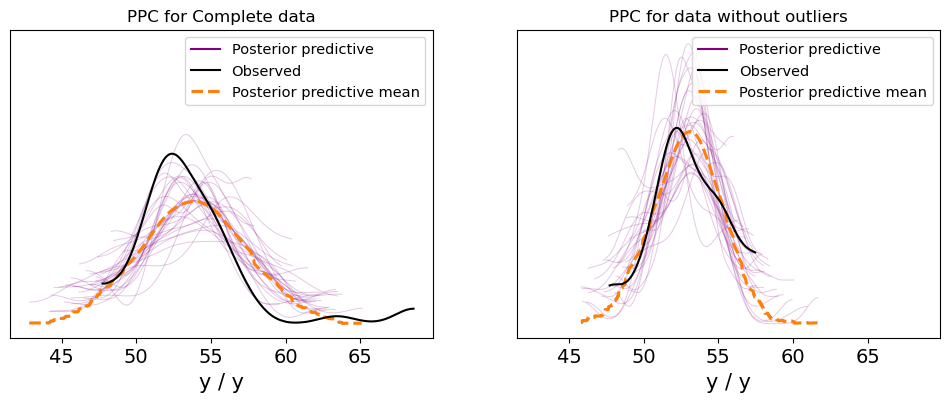

In [65]:


_, ax = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 4))
ax0 = arviz.plot_ppc(data=ppc_data,num_pp_samples= 30, data_pairs={"y":"y"}, color='purple', random_seed= 33, ax = ax[0])
ax1 = arviz.plot_ppc(data=ppc_data_reduced,num_pp_samples= 30, data_pairs={"y":"y"}, color='purple', random_seed= 33, ax=ax[1])
ax[0].set_title("PPC for Complete data")
ax[1].set_title("PPC for data without outliers")
plt.show()